### UPDATES:

- fixed two small edge cases:
    - remove self loops;
    - remove length one laterals
    
    
- plotted growth overtime
   
Haven't:
- convex hull:
    - https://gis.stackexchange.com/questions/360916/computing-convex-hull-of-points-using-shapely
    


In [206]:
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sns
import scipy 
import xmltodict
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

In [91]:
def add_root_path(G_root, root_dict, root_id, split = 'left', root_deg = 0):
    
    """
    helper func. No need to call
    """
    # add node:
    if type(root_dict) == list:
        for i, node in enumerate(root_dict):
            G_root.add_node((float(node['@coord_x']), float(node['@coord_y'])),
                            t = round(float(node['@coord_th'])),
                            root_id = root_id,
                            split = split,
                            root_deg = root_deg)
        

        # add edge:
        total_length = 0
        
        for i in range(len(root_dict)-1):
            u = (float(root_dict[i]['@coord_x']), float(root_dict[i]['@coord_y']))
            v =  (float(root_dict[i+1]['@coord_x']), float(root_dict[i+1]['@coord_y']))
            seg_length = scipy.spatial.distance.euclidean(u, v)
            G_root.add_edge(u, v, length = seg_length, t = max( G_root.nodes[u]['t'], G_root.nodes[v]['t']), split = split)
            total_length += seg_length

        G_root.graph[f'lengths_{split}'].append(total_length)
        
    return

In [3]:
def rsml2nx(file):
    """
    RSML to nx directed graph, left and right split root nodes are labeled.
    """

    # convert xml to dict:
    with open(file, 'r', encoding='utf-8') as file:
        rsml = file.read()

    RSA_dict = xmltodict.parse(rsml)
    
    G_root = nx.DiGraph()
    
    G_root.graph['lengths_left'] = []
    G_root.graph['lengths_right'] = []
    
    
    if  RSA_dict['rsml']['scene']['plant'][0]['root']['geometry']['polyline']['point'][0]['@coord_x'] < RSA_dict['rsml']['scene']['plant'][1]['root']['geometry']['polyline']['point'][0]['@coord_x']:       
        # read left:
        left = RSA_dict['rsml']['scene']['plant'][0]
        # read right:
        right = RSA_dict['rsml']['scene']['plant'][1]
    else:
         # read right:
        right = RSA_dict['rsml']['scene']['plant'][0]
        # read left:
        left = RSA_dict['rsml']['scene']['plant'][1]

    # primary root:
    primary = left['root']['geometry']['polyline']['point']
    add_root_path(G_root, primary, root_id = left['root']['@ID'], split = 'left', root_deg = 0)

    # lateral roots:
    for lr in left['root']['root']:
        # for each lateral:
        lateral = lr['geometry']['polyline']['point']
        add_root_path(G_root, lateral, root_id = lr['@ID'], split = 'left', root_deg = 1)

    # primary root:
    primary = right['root']['geometry']['polyline']['point']
    add_root_path(G_root, primary, root_id = right['root']['@ID'], split = 'right', root_deg = 0)
    
    # lateral roots:
    for lr in right['root']['root']:
        # for each lateral:
        lateral = lr['geometry']['polyline']['point']
        add_root_path(G_root, lateral, root_id = lr['@ID'], split = 'right', root_deg = 1)
    
    
    # remove self loops:
    G_root.remove_edges_from(nx.selfloop_edges(G_root))
    pos = np.array(list(G_root.nodes()))

    

    # save plotting ratio:
    mins = np.min(pos, 0)
    maxes = np.max(pos, 0)

    G_root.graph['x_min'] = mins[0]
    G_root.graph['y_min'] = mins[1]

    G_root.graph['x_max'] = maxes[0]
    G_root.graph['y_max'] = maxes[1]

    G_root.graph['ratio'] = (maxes[0] - mins[0]) / (maxes[1] - mins[1])
    
    return G_root, RSA_dict


In [88]:
def plot_rsmlt(G, plate):
    pos = np.array(list(G_root.nodes()))

    node_positions = {}
    node_color = []

    for node in G_root.nodes:
        node_positions[node] = ( node[0], - node[1])
        node_color.append(G_root.nodes[node]['t'])

    fig, ax = plt.subplots(figsize = (14,10/G_root.graph['ratio']))

    nx.draw(G_root, pos=node_positions, node_size = 0, width = .7, arrowsize = 5, ax = ax)
    split_root_node = nx.draw_networkx_nodes(G_root, pos=node_positions, node_size= 10, node_color = node_color, ax = ax,  cmap=plt.cm.magma) 
    ax.set_title(f'RSML + t, plate {plate} example', fontsize = 20)
    plt.colorbar(split_root_node, aspect= 50, shrink = .5, label = 'appiration time (h)', orientation = 'vertical')
    plt.tight_layout()
    
    plt.show()  
    
#     fig.savefig(f'SR_rsml_pilot/output/{plate}_RSMLt.pdf')

In [84]:
def get_growth(G_root):
    left_lengths = [ [] for _ in range(187//6) ]

    for edge in G_root.edges:
        if G_root.edges[edge]['split'] == 'left':
            length = G_root.edges[edge]['length']
            left_lengths[G_root.edges[edge]['t']//6-1].append(length)

    left_growth = []
    for i in range(len(left_lengths)):
        tot = np.array(left_lengths[i]).sum()
        left_growth.append(tot)

    left_tot = []
    running = 0
    for i in range(len(left_growth)):
        running += left_growth[i]
        left_tot.append(running)


    right_lengths = [ [] for _ in range(187//6) ]

    for edge in G_root.edges:
        if G_root.edges[edge]['split'] == 'right':
            length = G_root.edges[edge]['length']
            right_lengths[G_root.edges[edge]['t']//6-1].append(length)

    right_growth = []
    for i in range(len(right_lengths)):
        tot = np.array(right_lengths[i]).sum()
        right_growth.append(tot)

    right_tot = []
    running = 0
    for i in range(len(right_growth)):
        running += right_growth[i]
        right_tot.append(running)

    return left_lengths, left_tot, right_lengths, right_tot

In [97]:
def plot_growth(left_tot, right_tot, plate):
    fig, ax = plt.subplots(figsize = [8,6])
    plt.plot(np.array(left_tot)*19/1000, label = 'left')
    plt.plot(np.array(right_tot)*19/1000, label = 'right')
    plt.legend(fontsize = 14)
    tps = list(range(0, 187, 6))
    xticks = list(range(0, 32, 1))
    ax.set_xticks(xticks[::6])
    ax.set_xticklabels(tps[::6])
    ax.set_xlabel('hours', fontsize = 14)
    ax.set_ylabel('total length (mm)', fontsize = 14)
    ax.set_title(f'{plate} growth curve', fontsize = 16)
    ax.set_ylim([0, 200])
    plt.show()
    
    fig.savefig(f'SR_rsml_pilot/output/{plate}_growth_curve.pdf')

p55


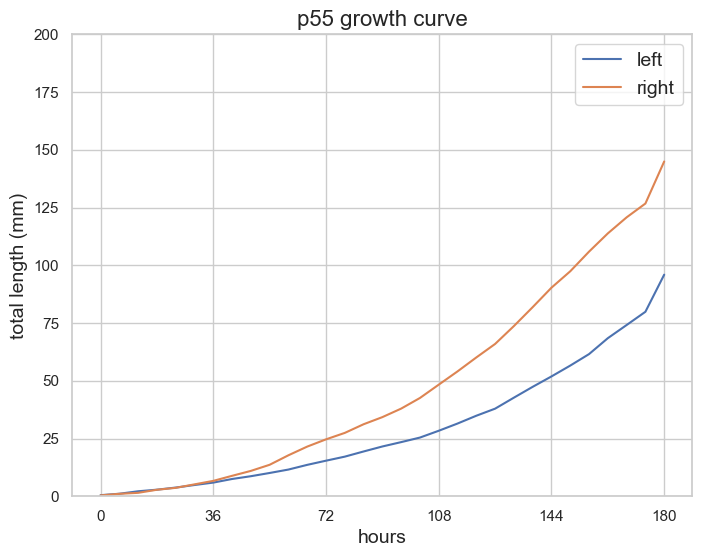

p56


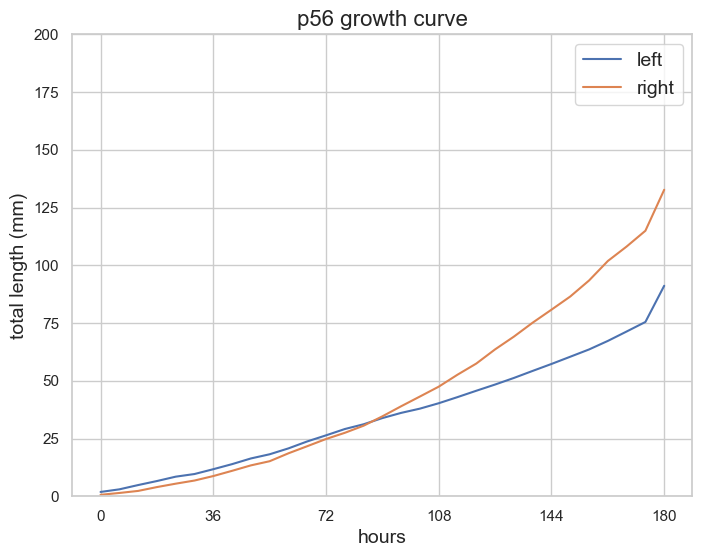

p58


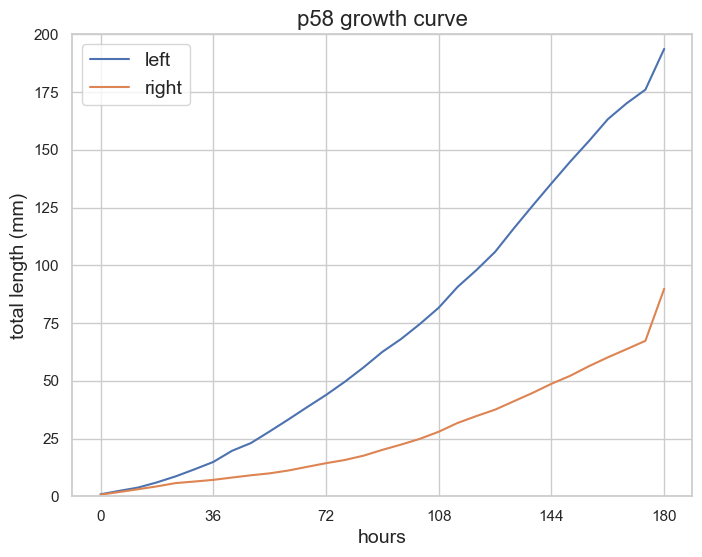

p59


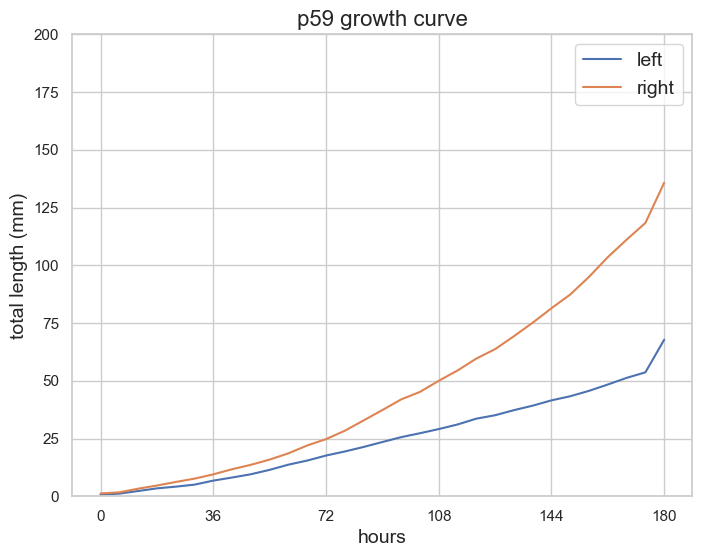

p60


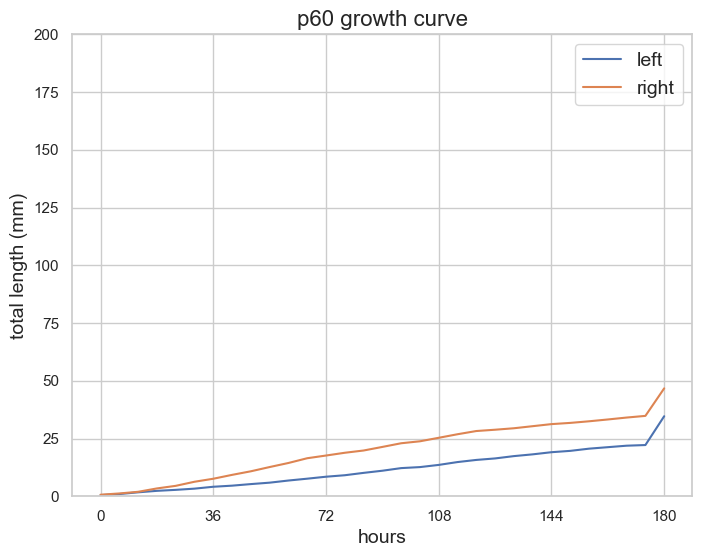

p61


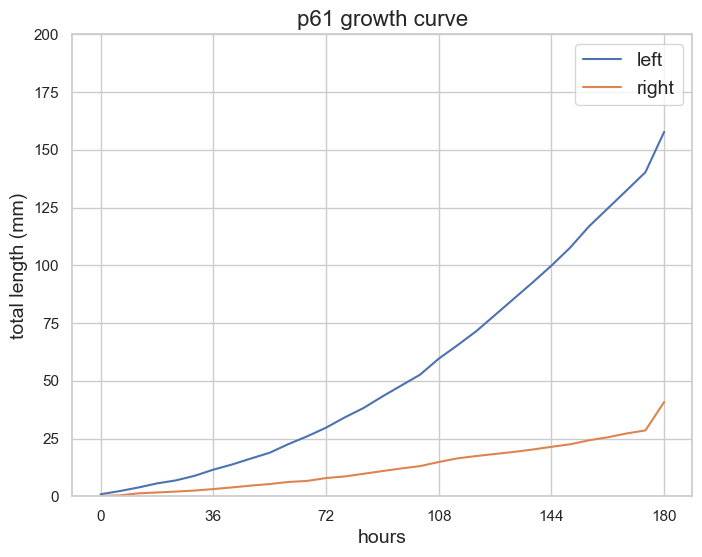

p77


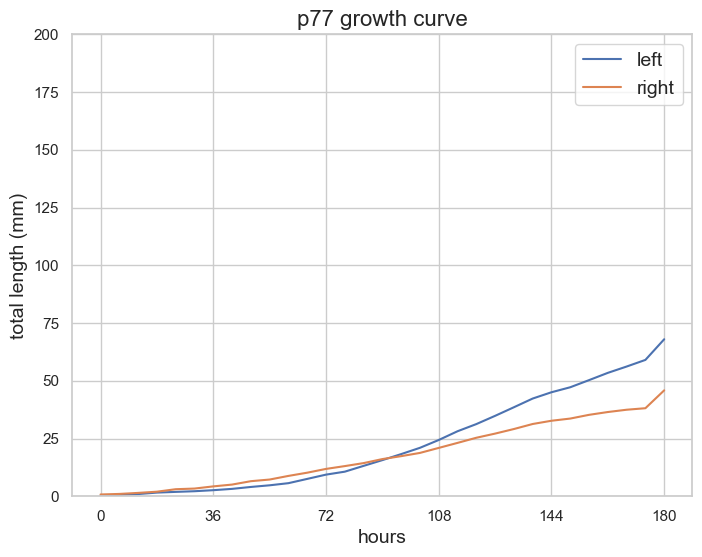

p78


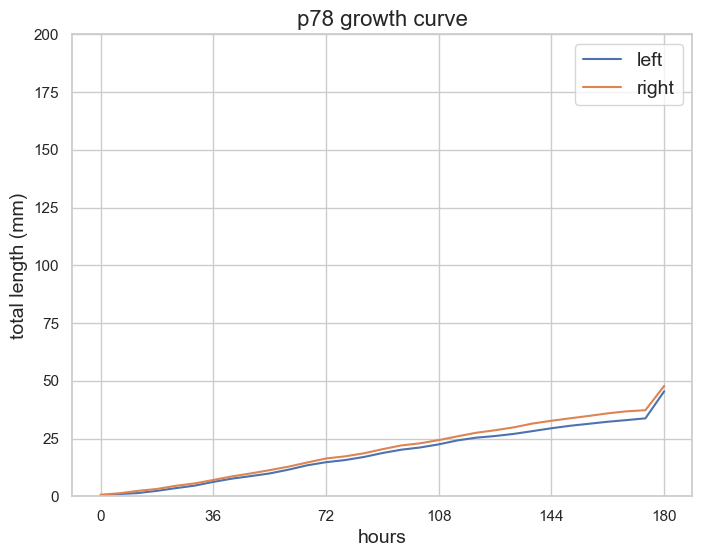

p79


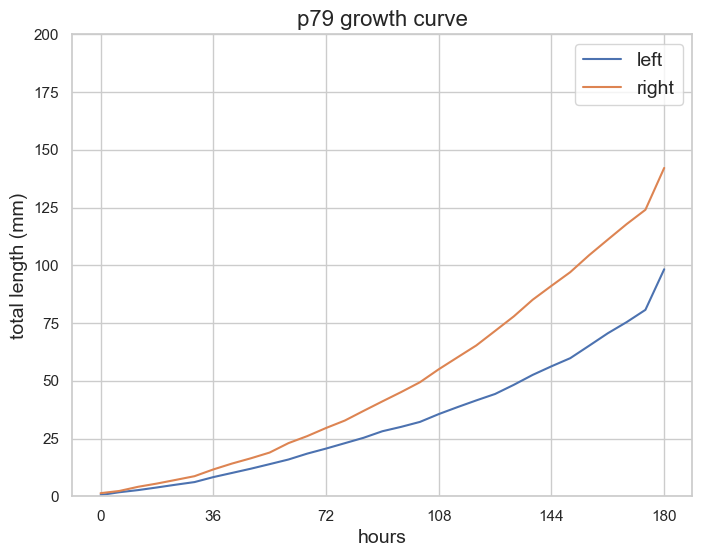

p80


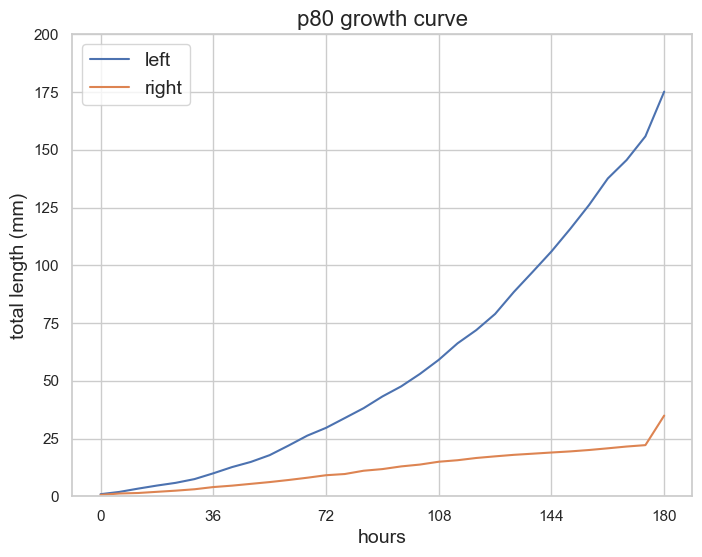

p84


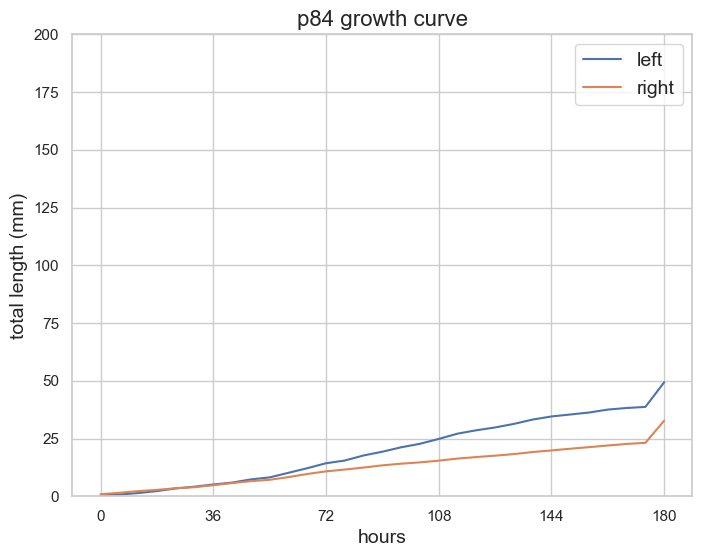

p87


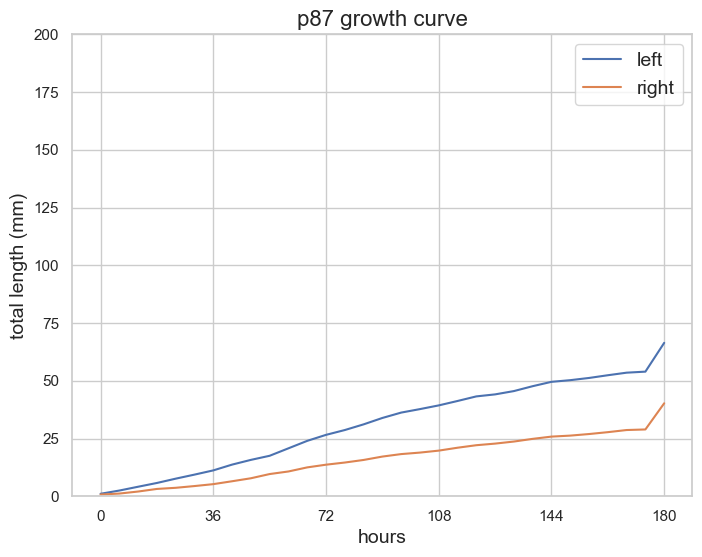

In [104]:
plate_list = ['p55', 'p56', 'p58', 'p59', 'p60', 'p61', 'p77','p78','p79','p80', 'p84', 'p87']

G_list = []
for plate in plate_list:
    print(plate)
    G_root, _ = rsml2nx(f'SR_rsml_pilot/{plate}.rsml')
    G_list.append(G_root)
    left_lengths, left_tot, right_lengths, right_tot = get_growth(G_root)
    plot_growth(left_tot, right_tot, plate)

In [105]:
plate_list = ['p55', 'p56', 'p58', 'p59', 'p60', 'p61', 'p77','p78','p79','p80', 'p84', 'p87']
conditions = ['YY', 'NY', 'YY', 'NY', 'NN', 'YY', 'YN', 'NN', 'YY', 'YN', 'NN', 'NN']

In [183]:
root_arr = np.zeros((12,4))
for i, G_root in enumerate(G_list):
    print('left number LR:', len(G_root.graph['lengths_left']) - 1)
    root_arr[i][0] = len(G_root.graph['lengths_left']) - 1
    print('right number of LR:', len(G_root.graph['lengths_right']) - 1)
    root_arr[i][1] = len(G_root.graph['lengths_right']) - 1
    print('left total length(pixel):', round(np.array(G_root.graph['lengths_left']).sum()))
    root_arr[i][2] = round(np.array(G_root.graph['lengths_left']).sum())*19/1000
    print('right total length(pixel):', round(np.array(G_root.graph['lengths_right']).sum()))
    root_arr[i][3] = round(np.array(G_root.graph['lengths_right']).sum())*19/1000
    print()

left number LR: 44
right number of LR: 40
left total length(pixel): 5049
right total length(pixel): 7627

left number LR: 34
right number of LR: 33
left total length(pixel): 4796
right total length(pixel): 6983

left number LR: 51
right number of LR: 32
left total length(pixel): 10192
right total length(pixel): 4729

left number LR: 32
right number of LR: 46
left total length(pixel): 3568
right total length(pixel): 7144

left number LR: 19
right number of LR: 30
left total length(pixel): 1831
right total length(pixel): 2464

left number LR: 41
right number of LR: 23
left total length(pixel): 8303
right total length(pixel): 2149

left number LR: 24
right number of LR: 23
left total length(pixel): 3577
right total length(pixel): 2413

left number LR: 20
right number of LR: 19
left total length(pixel): 2391
right total length(pixel): 2514

left number LR: 35
right number of LR: 36
left total length(pixel): 5172
right total length(pixel): 7480

left number LR: 38
right number of LR: 15
lef

In [184]:
root_df = pd.DataFrame(root_arr, columns = ['left_num_LR',  'right_num_LR', 'left_tot_length', 'right_tot_length'], index =  plate_list)

In [185]:
root_df['condition'] = conditions

In [186]:
root_df['tot_num_LR'] = root_df['left_num_LR'] + root_df['right_num_LR']

In [187]:
root_df['tot_length'] = root_df['left_tot_length'] + root_df['right_tot_length']

In [188]:
root_df['tot_nutrient'] = [2, 1, 2, 1, 0,2, 1, 0, 2, 1, 0, 0]

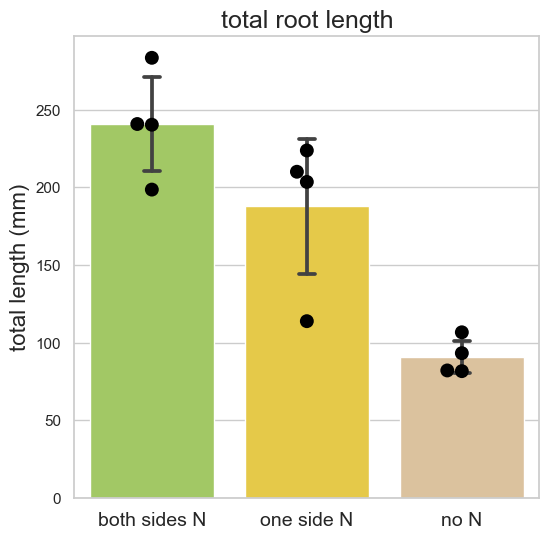

In [189]:
fig, ax = plt.subplots(figsize = [6,6])
order = [2, 1, 0]
colors = [sns.color_palette("Set2")[-4], sns.color_palette("Set2")[-3], sns.color_palette("Set2")[-2]]
palette = dict(zip(order, colors))

sns.barplot(x="tot_nutrient", y="tot_length", 
            data=root_df, capsize=.1, ci="sd", 
            order = order, palette = palette, ax = ax)
sns.swarmplot(x="tot_nutrient", y="tot_length", data=root_df, order = order, color = 'black', size = 10, ax = ax)

ax.set_xticklabels(['both sides N', 'one side N', 'no N'], fontsize = 14)
ax.set_xlabel(None)
ax.set_ylabel('total length (mm)', fontsize = 16)
ax.set_title('total root length', fontsize = 18)
plt.show()

fig.savefig('SR_rsml_pilot/output/total_length.pdf')


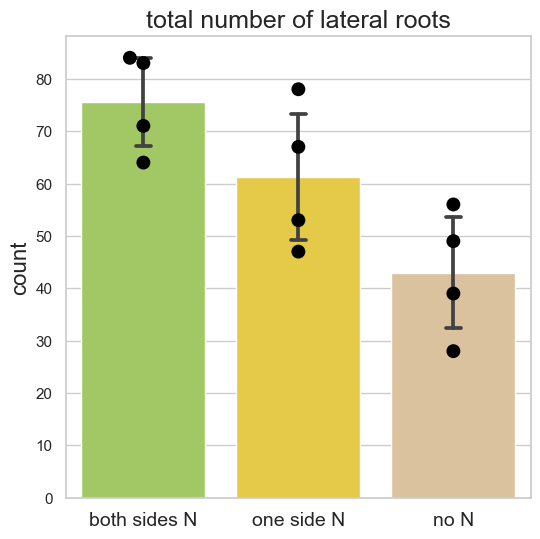

In [190]:
fig, ax = plt.subplots(figsize = [6,6])
order = [2, 1, 0]
colors = [sns.color_palette("Set2")[-4], sns.color_palette("Set2")[-3], sns.color_palette("Set2")[-2]]
palette = dict(zip(order, colors))

sns.barplot(x="tot_nutrient", y="tot_num_LR", 
            data=root_df, capsize=.1, ci="sd", 
            order = order, palette = palette, ax = ax)
sns.swarmplot(x="tot_nutrient", y="tot_num_LR", data=root_df, order = order, color = 'black', size = 10, ax = ax)


ax.set_xticklabels(['both sides N', 'one side N', 'no N'], fontsize = 14)
ax.set_xlabel(None)
ax.set_ylabel('count', fontsize = 16)
ax.set_title('total number of lateral roots', fontsize = 18)

fig.savefig('SR_rsml_pilot/output/total_lateral.pdf')

plt.show()




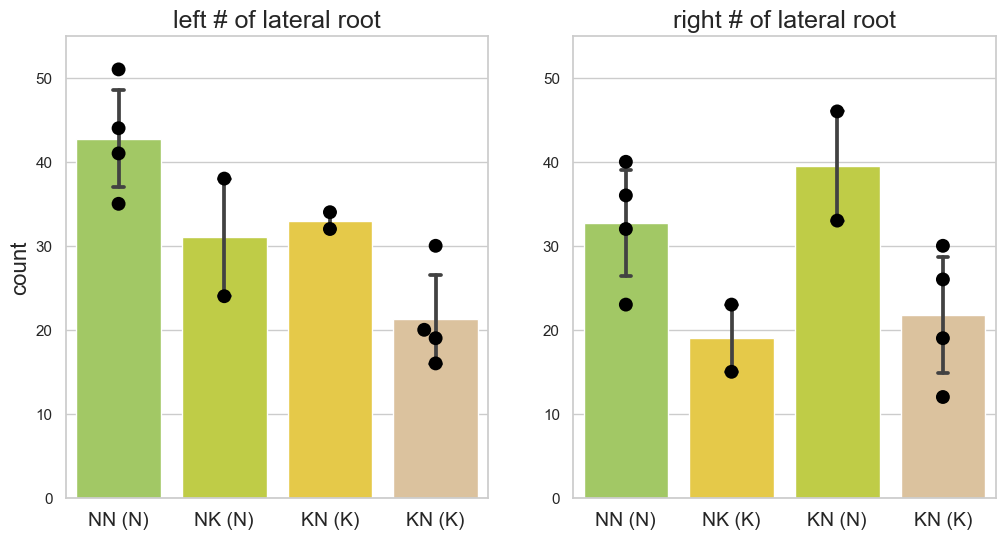

In [203]:
fig, ax = plt.subplots(ncols = 2, figsize = [12,6])
order = ['YY', 'YN', 'NY', 'NN']
colors = [sns.color_palette("Set2")[-4],  '#d1e231', sns.color_palette("Set2")[-3], sns.color_palette("Set2")[-2]]
palette = dict(zip(order, colors))

sns.barplot(x="condition", y="left_num_LR", 
            data=root_df, capsize=.1, ci="sd", 
            order = order, palette = palette, ax = ax[0])
sns.swarmplot(x="condition", y="left_num_LR", data=root_df, order = order, color = 'black', size = 10, ax = ax[0])
ax[0].set_ylabel('count', fontsize = 16)
ax[0].set_xticklabels(['NN (N)', 'NK (N)', 'KN (K)', 'KN (K)'], fontsize = 14)
ax[0].set_xlabel(None)
ax[0].set_ylim([0, 55])
ax[0].set_title('left # of lateral root', fontsize = 18)

order = ['YY', 'YN', 'NY', 'NN']
colors = [sns.color_palette("Set2")[-4], sns.color_palette("Set2")[-3],  '#d1e231', sns.color_palette("Set2")[-2]]
palette = dict(zip(order, colors))

sns.barplot(x="condition", y="right_num_LR", 
            data=root_df, capsize=.1, ci="sd", 
            order = order, palette = palette, ax = ax[1])
sns.swarmplot(x="condition", y="right_num_LR", data=root_df, order = order, color = 'black', size = 10, ax = ax[1])
ax[1].set_ylabel(None)
ax[1].set_xticklabels(['NN (N)', 'NK (K)', 'KN (N)', 'KN (K)'], fontsize = 14)
ax[1].set_xlabel(None)
ax[1].set_ylim([0, 55])
ax[1].set_title('right # of lateral root', fontsize = 18)

fig.savefig('SR_rsml_pilot/output/split_lateral.pdf')


plt.show()

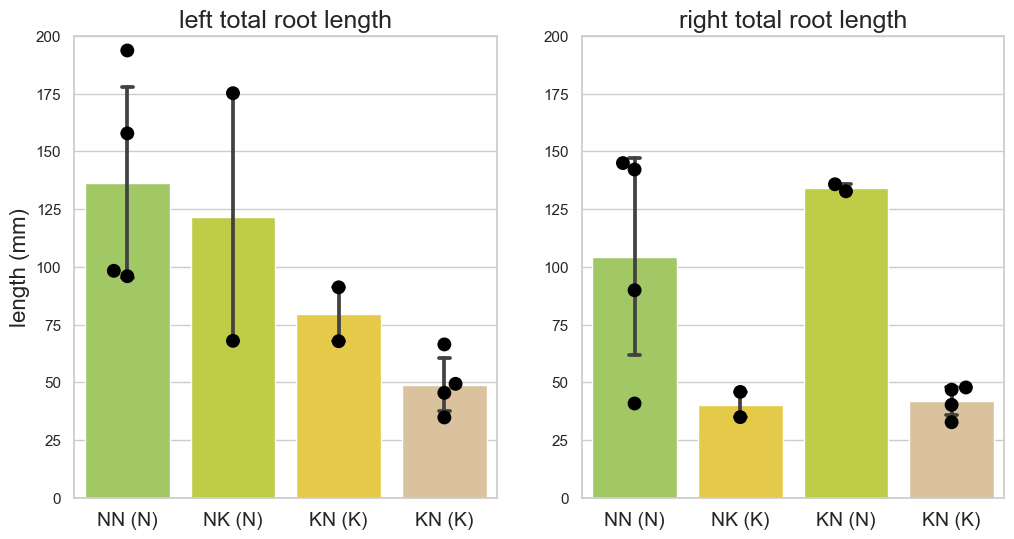

In [204]:
fig, ax = plt.subplots(ncols = 2, figsize = [12,6])
order = ['YY', 'YN', 'NY', 'NN']
colors = [sns.color_palette("Set2")[-4],  '#d1e231', sns.color_palette("Set2")[-3], sns.color_palette("Set2")[-2]]
palette = dict(zip(order, colors))

sns.barplot(x="condition", y="left_tot_length", 
            data=root_df, capsize=.1, ci="sd", 
            order = order, palette = palette, ax = ax[0])
sns.swarmplot(x="condition", y="left_tot_length", data=root_df, order = order, color = 'black', size = 10, ax = ax[0])
ax[0].set_ylabel('length (mm)', fontsize = 16)
ax[0].set_xticklabels(['NN (N)', 'NK (N)', 'KN (K)', 'KN (K)'], fontsize = 14)
ax[0].set_xlabel(None)
ax[0].set_ylim([0, 200])
ax[0].set_title('left total root length', fontsize = 18)

order = ['YY', 'YN', 'NY', 'NN']
colors = [sns.color_palette("Set2")[-4], sns.color_palette("Set2")[-3],  '#d1e231', sns.color_palette("Set2")[-2]]
palette = dict(zip(order, colors))

sns.barplot(x="condition", y="right_tot_length", 
            data=root_df, capsize=.1, ci="sd", 
            order = order, palette = palette, ax = ax[1])
sns.swarmplot(x="condition", y="right_tot_length", data=root_df, order = order, color = 'black', size = 10, ax = ax[1])
ax[1].set_ylabel(None)
ax[1].set_xticklabels(['NN (N)', 'NK (K)', 'KN (N)', 'KN (K)'], fontsize = 14)
ax[1].set_xlabel(None)
ax[1].set_ylim([0, 200])
ax[1].set_title('right total root length', fontsize = 18)
fig.savefig('SR_rsml_pilot/output/split_count.pdf')

plt.show()